In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt


%matplotlib inline


def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1]: M. Duarte.  "Curve fitting," JUpyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t*s_err*np.sqrt(1/n + (x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    ax.fill_between(x2, y2+ci, y2-ci, color="#b9cfe7", edgecolor="")

    return ax


def plot_ci_bootstrap(n, x, y, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint
    nx = n 

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid)-1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(x, y + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(x, sp.polyval(pc,x), "b-", linewidth=2, alpha=3.0/float(nboot))

    return ax

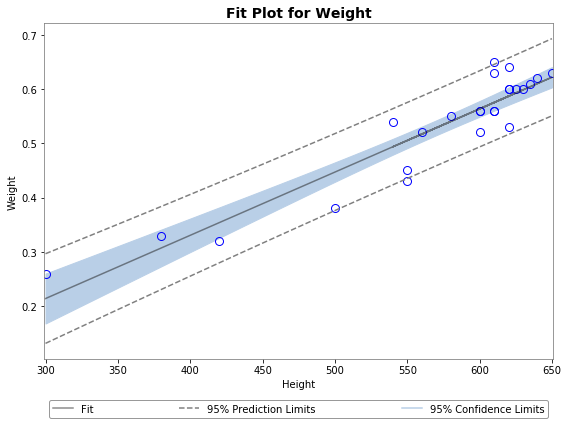

In [5]:
# Computations ----------------------------------------------------------------
# Raw Data
heights = np.array([300, 380, 420, 500, 580, 550, 550, 610, 560, 540, 600, 610, 620, 620, 600, 600, 620, 610, 630, 610, 625, 650, 640, 635, 620])
weights = np.array([0.26, 0.33, 0.32, 0.38, 0.55, 0.45, 0.43, 0.56, 0.52, 0.54, 0.56, 0.56, 0.6, 0.53, 0.56, 0.52, 0.6, 0.65, 0.6, 0.63, 0.6, 0.63, 0.62, 0.61, 0.64])

x = heights
y = weights

# Modeling with Numpy
p, cov = np.polyfit(x, y, 1, cov=True)        # parameters and covariance from of the fit
y_model = np.polyval(p, x)                    # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = weights.size                              # number of observations
m = p.size                                    # number of parameters
DF = n - m                                    # degrees of freedom
t = stats.t.ppf(0.95, n - m)                  # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid/y_model)**2)             # chi-squared; estimates error in data
chi2_red = chi2/(DF)                          # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2)/(DF))        # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))

# Data
ax.plot(x,y,"o", color="#b9cfe7", markersize=8,
         markeredgewidth=1,markeredgecolor="b",markerfacecolor="None")

# Fit
ax.plot(x,y_model,"-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = np.linspace(np.min(y_model), np.max(y_model), 100)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(n, x, y, resid, ax=ax)

# Prediction Interval
pi = t*s_err*np.sqrt(1+1/n+(x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))   
ax.fill_between(x2, y2+pi, y2-pi, color="None", linestyle="--")
ax.plot(x2, y2-pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2+pi, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Fit Plot for Weight", fontsize="14", fontweight="bold")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.xlim(np.min(x)-1,np.max(x)+1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0,1)
anyArtist = plt.Line2D((0,1),(0,0), color="#b9cfe7")  # Create custom artists
legend = plt.legend(
          [handle for i,handle in enumerate(handles) if i in display]+[anyArtist],
          [label for i,label in enumerate(labels) if i in display]+["95% Confidence Limits"],
          loc=9, bbox_to_anchor=(0, -0.21, 1., .102), ncol=3, mode="expand")  
frame = legend.get_frame().set_edgecolor("0.5")

# Save Figure
plt.tight_layout()
plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")

plt.show()

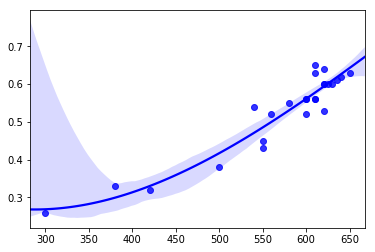

In [10]:
import seaborn as sns
heights = np.array([300, 380, 420, 500, 580, 550, 550, 610, 560, 540, 600, 610, 620, 620, 600, 600, 620, 610, 630, 610, 625, 650, 640, 635, 620])
weights = np.array([0.26, 0.33, 0.32, 0.38, 0.55, 0.45, 0.43, 0.56, 0.52, 0.54, 0.56, 0.56, 0.6, 0.53, 0.56, 0.52, 0.6, 0.65, 0.6, 0.63, 0.6, 0.63, 0.62, 0.61, 0.64])

sns.regplot(heights,weights, color ='blue', order=3, ci=80)

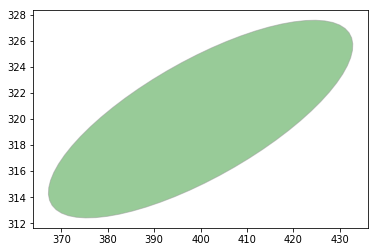

In [57]:
from matplotlib import pyplot
from shapely.geometry.point import Point
import shapely.affinity
from descartes import PolygonPatch
# Note: download figures.py manually from shapely github repo, put it in shapely install directory
from shapely.figures import SIZE, GREEN, GRAY, set_limits


# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
#400.0, 0.3225), (333.06661351131913, 0.05565460358823461), -179.96749566612493)
ellipse = ((400, 320),(333, 50), -100)
# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(0.1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, ellipse[1][0], ellipse[1][1])

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# If one need to rotate it clockwise along an upward pointing x axis:
elrv = shapely.affinity.rotate(ell,90-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.


fig = pyplot.figure()
ax = fig.add_subplot(111)
patch = PolygonPatch(elrv, fc=GREEN, ec=GRAY, alpha=0.5, zorder=2)
ax.add_patch(patch)
ax.autoscale()
pyplot.show()